01_Dataset_Preparation.ipynb

(A) 분야 및 데이터 출처 :

본 프로젝트는 컴퓨터 비전 분야에 해당하며, 특정 객체(칼)를 분류하는 이미지 분류 문제입니다.
주제와 데이터 모두 본인이 직접 생성하였으며, 영상 19개를 촬영한 후 이미지로 분할·가공하여 학습용 데이터를 구성하였습니다.

(B) 모델 목적:

다양한 실제 환경(조도, 배경, 오클루전, 칼 종류)에 따라 칼의 인식 정확도가 어떻게 달라지는지 비교하기 위해,
4가지 CNN 모델(VGG16, ResNet50, DenseNet121, EfficientNetB0)의 성능을 조건별로 분석하고
현실에서 강건한(robust) 칼 분류 모델을 탐색하는 것이 목적입니다.

(C) 데이터 종류 및 양 :


- 데이터 종류: 이미지 (RGB, 224x224)

- 데이터 출처: 본인이 직접 촬영한 영상 19편에서 프레임을 추출하여 가공

- 총 이미지 수: 약 15,800장

- 구성: 조도(bright/dark), 배경(5종), 오클루전 유무, 칼 종류(3종) 등 다양한 조건 조합으로 구성된 커스텀 데이터셋

(D) 입력 데이터 및 방식 :

각 모델에는 224x224 크기의 RGB 칼 이미지가 입력됩니다.
이미지는 전처리 과정을 거쳐 모델에 주어지며, 모델은 이를 기반으로 칼의 존재 여부 및 종류를 분류합니다.

(E) 출력 결과 및 의미

모델의 출력은 **분류 결과(label)**로, ‘커터칼’, ‘과도’, ‘식칼’, ‘칼 없음’ 중 하나를 예측합니다.

이를 기반으로 조건별 정확도를 분석하여, 환경 변화에 강한 최적의 모델을 도출하는 것이 실험의 핵심입니다.

# 01_Dataset_Preparation

## (1) 주제

칼 이미지에 대한 다양한 조건(조도, 배경, 칼 종류, 오클루전)을 반영한 이미지 분류 실험

---

## (2) Motivation

실생활에서 위험 물체(칼)를 다양한 환경에서 인식하는 것은 영상 처리 시스템의 중요한 문제 중 하나이다.

본 프로젝트에서는 YOLOv8을 활용해 직접 촬영한 영상에서 칼 이미지를 추출하고,

여러 CNN 기반 분류 모델(VGG16, ResNet50, DenseNet121, EfficientNetB0)을 비교하여,

환경 조건별로 어떤 모델이 효과적인지를 분석하고자 한다.



---

## (3) 사용하는 기존 (인터넷 상) 데이터 수급 방법에 대한 설명

본 프로젝트는 외부에서 수집한 공개 데이터셋을 사용하지 않았으며,  
모든 데이터는 본인이 직접 촬영한 영상으로부터 YOLOv8 모델을 활용하여 칼 이미지를 추출해 구성하였다.

[Note 1]

본 과제에서는 전이학습 기반 모델을 사용하였으며, 아래의 사전 학습(pre-trained) 모델들을 활용하였다.

- VGG16
- ResNet50
- DenseNet121
- EfficientNetB0

이들 모델은 Keras의 `keras.applications` 모듈을 통해 제공되며,  
`ImageNet` 데이터셋으로 사전 학습된 가중치를 불러와 출력층을 수정하여 분류 학습에 사용하였다.

외부에서 추가적으로 가져온 데이터는 없으며, 학습에는 본인이 직접 생성한 이미지 데이터만을 활용하였다.

[Note 2]

본 프로젝트는 본인이 직접 촬영한 19개의 영상(식칼, 과도, 커터칼 × 다양한 조건)을 기반으로 하고 있으며,  
이 영상들은 수업 과제 제출을 목적으로 촬영되었기 때문에 별도의 외부 공유 링크는 존재하지 않는다.

In [ ]:
# 1. Drive 마운트

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


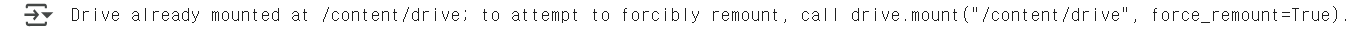

In [ ]:
# 2. 라이브러리 설치

!pip install ultralytics opencv-python --quiet

In [ ]:
# 3. YOLOv8 모델 로드 및 탐지 함수 정의

from ultralytics import YOLO
model = YOLO('yolov8s.pt')  # 실험용 데이터셋 생성에 최적

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 150MB/s] 


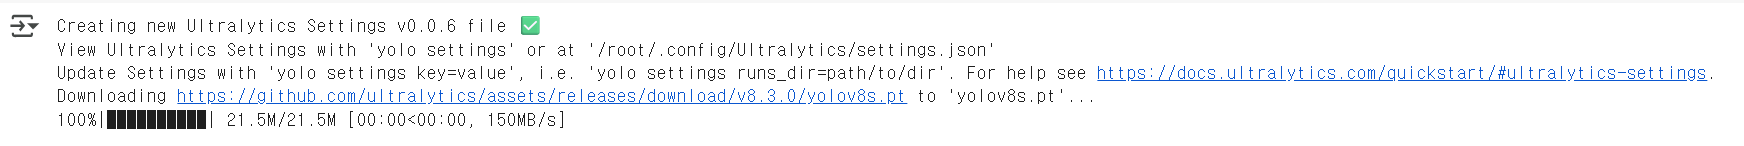

In [ ]:
# 4. 영상 경로 설정

video_base_path = "/content/drive/MyDrive/knife_videos"

In [ ]:
# 5. 탐지 함수 정의

import cv2
import os

def extract_knives_from_video(video_path, save_dir, conf=0.25, save_limit=50):
    os.makedirs(save_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved = 0

    while cap.isOpened() and saved < save_limit:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)
        for result in results:
            for box in result.boxes:
                cls = int(box.cls[0])
                label = model.names[cls]

                if label == 'knife':
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    crop = frame[y1:y2, x1:x2]
                    filename = f"{save_dir}/knife_{frame_count:04d}.jpg"
                    cv2.imwrite(filename, crop)
                    saved += 1

        frame_count += 1

    cap.release()
    print(f"[{os.path.basename(video_path)}] 저장 완료: {saved}장")

In [ ]:
# 6. 영상 리스트 반복 처리

video_files = [
    "knife01_bright_kitchen_식칼_none.mp4",
    "knife02_dark_desk_과도_none.mp4",
    "knife03_bright_livingroom_커터칼_yes.mp4",
    "knife04_bright_floor_식칼_none.mp4",
    "knife05_dark_kitchen_과도_yes.mp4",
    "knife06_bright_window_커터칼_none.mp4",
    "knife07_bright_desk_식칼_yes.mp4",
    "knife08_dark_livingroom_커터칼_none.mp4",
    "knife09_dark_floor_커터칼_yes.mp4",
    "knife10_dark_window_커터칼_yes.mp4",
    "knife11_bright_floor_커터칼_yes.mp4",
    "knife12_dark_kitchen_커터칼_none.mp4",
    "knife13_bright_window_커터칼_yes.mp4",
    "knife14_dark_floor_과도_yes.mp4",
    "knife15_bright_kitchen_과도_none.mp4",
    "knife16_bright_floor_과도_yes.mp4",
    "knife17_bright_desk_식칼_yes.mp4",
    "knife18_bright_window_커터칼_yes.mp4",
    "knife19_dark_livingroom_식칼_none.mp4"
]

for file in video_files:
    video_path = os.path.join(video_base_path, file)
    save_dir = f"/content/knives_dataset/{file.replace('.mp4','')}"
    extract_knives_from_video(video_path, save_dir)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Speed: 1.8ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 scissors, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 baseball bat, 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 baseball bat, 1 scissors, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 baseball bat, 1 toothbrush, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 baseball bat, 1 toothbrush, 9.9ms
Speed: 4.0ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 baseball bat, 10.1ms
Speed: 5.3ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (

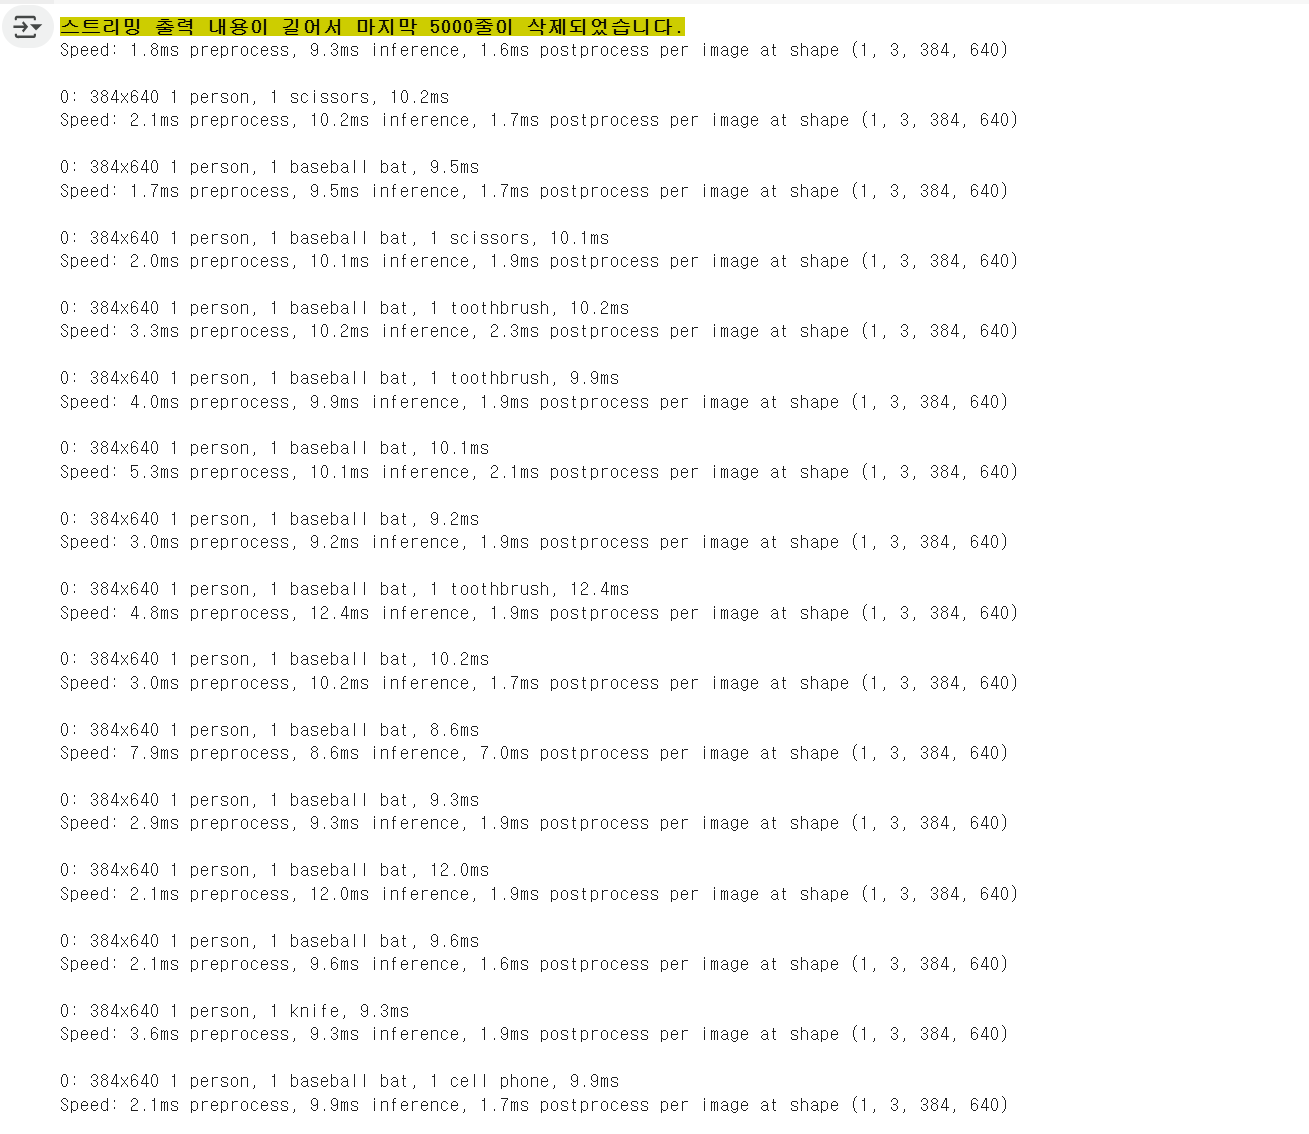

## (4) 본인이 생성한 데이터 평가

본 프로젝트에서 사용한 데이터는 본인이 직접 생성한 이미지 데이터이다.  
총 19개의 조건 조합(조도, 배경, 칼 종류, 오클루전 포함)에 따라 영상을 촬영하였고,  
YOLOv8 객체 탐지 모델을 활용하여 각 영상으로부터 칼 객체만을 crop하여 이미지로 저장하였다.

| 번호 | 조도  | 배경 | 오클루전 | 칼 종류 | 파일명                                       |
| -- | --- | -- | ---- | ---- | ----------------------------------------- |
| 1  | 밝음  | 주방 | 없음   | 식칼   | knife01\_bright\_kitchen\_식칼\_none.mp4    |
| 2  | 어두움 | 책상 | 없음   | 과도   | knife02\_dark\_desk\_과도\_none.mp4         |
| 3  | 밝음  | 거실 | 있음   | 커터칼  | knife03\_bright\_livingroom\_커터칼\_yes.mp4 |
| 4  | 밝음  | 바닥 | 없음   | 식칼   | knife04\_bright\_floor\_식칼\_none.mp4      |
| 5  | 어두움 | 주방 | 있음   | 과도   | knife05\_dark\_kitchen\_과도\_yes.mp4       |
| 6  | 밝음  | 창가 | 없음   | 커터칼  | knife06\_bright\_window\_커터칼\_none.mp4    |
| 7  | 밝음  | 책상 | 있음   | 식칼   | knife07\_bright\_desk\_식칼\_yes.mp4        |
| 8  | 어두움 | 거실 | 없음   | 커터칼  | knife08\_dark\_livingroom\_커터칼\_none.mp4  |
| 9  | 어두움 | 바닥 | 있음   | 커터칼  | knife09\_dark\_floor\_커터칼\_yes.mp4        |
| 10 | 어두움 | 창가 | 있음   | 커터칼  | knife10\_dark\_window\_커터칼\_yes.mp4       |
| 11 | 밝음  | 바닥 | 있음   | 커터칼  | knife11\_bright\_floor\_커터칼\_yes.mp4      |
| 12 | 어두움 | 주방 | 없음   | 커터칼  | knife12\_dark\_kitchen\_커터칼\_none.mp4     |
| 13 | 밝음  | 창가 | 있음   | 커터칼  | knife13\_bright\_window\_커터칼\_yes.mp4     |
| 14 | 어두움 | 바닥 | 있음   | 과도   | knife14\_dark\_floor\_과도\_yes.mp4         |
| 15 | 밝음  | 주방 | 없음   | 과도   | knife15\_bright\_kitchen\_과도\_none.mp4    |
| 16 | 밝음  | 바닥 | 있음   | 과도   | knife16\_bright\_floor\_과도\_yes.mp4       |
| 17 | 밝음  | 책상 | 있음   | 식칼   | knife17\_bright\_desk\_식칼\_yes.mp4        |
| 18 | 밝음  | 창가 | 있음   | 커터칼  | knife18\_bright\_window\_커터칼\_yes.mp4     |
| 19 | 어두움 | 거실 | 없음   | 식칼   | knife19\_dark\_livingroom\_식칼\_none.mp4   |


[Note 3] 생성한 데이터셋은 이주원의 Github (https://github.com/jwdebbie/knife-classification) 에 업로드되어 있으며, 해당 데이터 링크를 프로그램에서 불러 딥러닝 프로그래밍을 진행한다.

[Note 4] 데이터는 집에서 어머니와 함께 직접 촬영한 영상데이터를 활용하였다. 데이터 편향 극복을 위해 8개의 영상에서 총 19개의 영상으로 그 수를 늘려서 균형을 확보하였다.

[Note 5] 본 프로젝트의 데이터는 동영상에서 추출한 이미지 프레임으로 구성된 이미지 데이터이며, 다양한 조건(조도, 배경, 오클루전 등)에 따른 패턴 인식이 가능하도록 설계되었다.

In [ ]:
# 생성된 데이터셋 .zip으로 압축하기 (github 올리기용)

!zip -r knives_dataset.zip knives_dataset

  adding: knives_dataset/ (stored 0%)
  adding: knives_dataset/knife02_dark_desk_과도_none/ (stored 0%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0035.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0056.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0005.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0030.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0011.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0033.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0040.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0043.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0048.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0019.jpg (deflated 2%)
  adding: knives_dataset/knife02_dark_desk_과도_none/knife_0002.jpg (deflated 2%)
  adding: knives_d

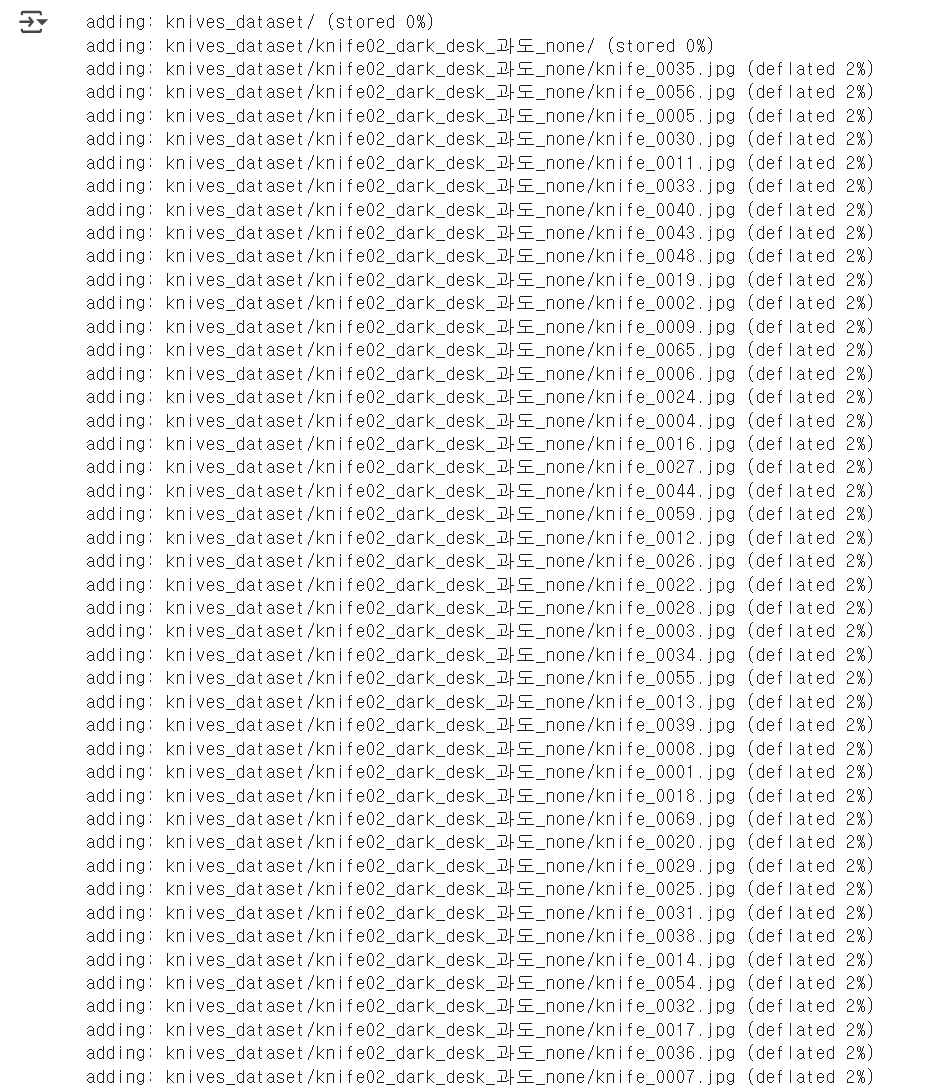